In [1]:
import numpy as np
import pandas as pd

np.random.seed(123)

ex_df_path = "/Users/tie_zhao/Desktop/Soma_QC_re/Results/06.multi_modal_check/PHOMday0_vs_NAGA.ex.multimodal.csv"
apt_df_path = "/Users/tie_zhao/Desktop/Soma_QC_re/Results/06.multi_modal_check/PHOMday0_vs_NAGA.apt.multimodal.csv"
age_sex_df_path = "/Users/tie_zhao/Desktop/Soma_QC_re/DataSrc/BIC_model_comparison_sex_age_bmi.utf8.csv"
my_age_sex_df_path = "/Users/tie_zhao/Desktop/Soma_QC_re/DataSrc/sample.csv"

ex_df = pd.read_csv(ex_df_path, index_col=0)
apt_df = pd.read_csv(apt_df_path)
age_sex_df = pd.read_csv(age_sex_df_path)
my_age_sex_df = pd.read_csv(my_age_sex_df_path, index_col=0)

In [2]:
my_age_sex_df['sex_male1_female2'] = my_age_sex_df['sex_male1_female2'].replace(2, 0)
my_age_sex_df = my_age_sex_df.rename(columns={'sex_male1_female2': 'sex'})
my_age_sex_df = my_age_sex_df[my_age_sex_df.index.str.startswith('NAG')]

In [3]:
seqid_list = 'X' + age_sex_df['SeqId'].astype(str)
apt_df['in_janice_check'] = apt_df['SeqId'].isin(seqid_list)

In [4]:
age_sex_df['SeqId'] = 'X' + age_sex_df['SeqId']

In [5]:
insert_apt = []

for seq_id in age_sex_df['SeqId']:
    if seq_id in ex_df.columns:
        insert_apt.append(seq_id)

filtered_ex_df = ex_df[insert_apt]
filtered_age_sex_df = age_sex_df[age_sex_df['SeqId'].isin(insert_apt)]
filtered_age_sex_df = filtered_age_sex_df.iloc[:, :5]

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_filtered_ex_df = scaler.fit_transform(filtered_ex_df)
scaled_filtered_ex_df = pd.DataFrame(scaled_filtered_ex_df, index=filtered_ex_df.index, columns=filtered_ex_df.columns)

filtered_scaled_naga_ex_df = scaled_filtered_ex_df[scaled_filtered_ex_df.index.str.startswith('NAG')]


In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


def p_to_std_z(beta, p_value):
    # calculate the standard error of beta
    z_stat = norm.ppf(1 - p_value / 2)
    
    if z_stat == float('inf') or z_stat == 0:
        return 0.0001 # avoid division by zero
    
    se = abs(beta / z_stat)
    
    return max(se, 0.0001)

protein_id = 'X10643-16'


beta_sex = filtered_age_sex_df.loc[filtered_age_sex_df['SeqId'] == protein_id, 'model1_beta_sex'].iloc[0]
pvalue_sex = filtered_age_sex_df.loc[filtered_age_sex_df['SeqId'] == protein_id, 'model1_pvalue_sex'].iloc[0]
beta_age = filtered_age_sex_df.loc[filtered_age_sex_df['SeqId'] == protein_id, 'model1_beta_age'].iloc[0]
pvalue_age = filtered_age_sex_df.loc[filtered_age_sex_df['SeqId'] == protein_id, 'model1_pvalue_age'].iloc[0]

std_sex = p_to_std_z(beta_sex, pvalue_sex) 
std_age = p_to_std_z(beta_age, pvalue_age)

protein_levels = filtered_scaled_naga_ex_df[protein_id].values
sample_data = my_age_sex_df.loc[filtered_scaled_naga_ex_df.index]

# Plot the protein levels distribution
with PdfPages('protein_levels_plots.pdf') as pdf:
    
    plt.style.use('default')
    
    # Plot the protein levels distribution
    plt.figure()
    sns.kdeplot(np.log2(protein_levels), shade=True, color="blue", label="Protein Levels")
    plt.title("Protein Levels ($\log_2$) Distribution")
    plt.xlabel("")
    plt.ylabel("Density")
    plt.legend()
    pdf.savefig()
    plt.close()

    # Plot the protein levels distribution depending on sex
    plt.figure()
    sns.kdeplot(data=sample_data, x=np.log2(protein_levels), hue="sex", shade=True)
    plt.title("Protein Levels ($\log_2$) Distribution by Sex")
    plt.xlabel("")
    plt.ylabel("Density")
    pdf.savefig()
    plt.close()

    # Plot the protein levels distribution depending on age
    sample_data['age_group'] = pd.qcut(sample_data['age'], q=2)
    sample_data['age_group'] = sample_data['age_group'].astype(str).str.replace(r'\.\d+', '', regex=True)
    plt.figure()
    sns.kdeplot(data=sample_data, x=np.log2(protein_levels), hue="age_group", shade=True)
    plt.title("Protein Levels ($\log_2$) Distribution by Age Group")
    plt.xlabel("")
    plt.ylabel("Density")
    pdf.savefig()
    plt.close()

/var/folders/kc/cfxf5cp17lj03hc5brjwtxjh0000gq/T/ipykernel_96158/3303196219.py:43: RuntimeWarning: invalid value encountered in log2
  sns.kdeplot(np.log2(protein_levels), shade=True, color="blue", label="Protein Levels")
/var/folders/kc/cfxf5cp17lj03hc5brjwtxjh0000gq/T/ipykernel_96158/3303196219.py:43: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log2(protein_levels), shade=True, color="blue", label="Protein Levels")
/var/folders/kc/cfxf5cp17lj03hc5brjwtxjh0000gq/T/ipykernel_96158/3303196219.py:53: RuntimeWarning: invalid value encountered in log2
  sns.kdeplot(data=sample_data, x=np.log2(protein_levels), hue="sex", shade=True)
/var/folders/kc/cfxf5cp17lj03hc5brjwtxjh0000gq/T/ipykernel_96158/3303196219.py:53: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your cod

Identified Peaks: [-0.16921106 -0.05278502]


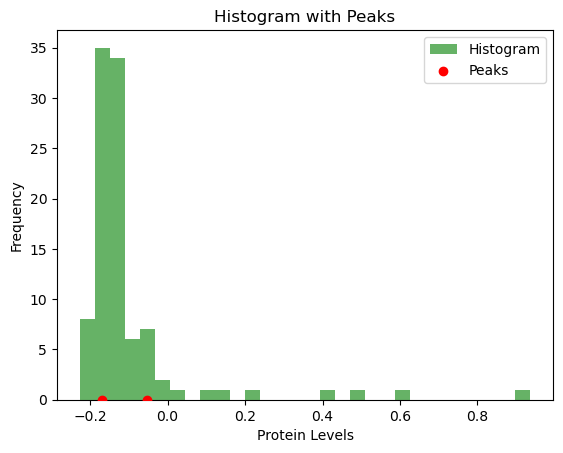

In [8]:
from scipy.signal import find_peaks

def find_top_two_peaks(data, bins=30):
    # find the peaks in the histogram of the data
    counts, bin_edges = np.histogram(data, bins=bins)
    peaks, _ = find_peaks(counts)
    
    if len(peaks) == 0:
        # when no peaks are found, return the maximum and minimum values
        return np.array([1, 0])
    elif len(peaks) == 1:
        # when only one peak is found, return the value of the peak and 0
        peak_value = (bin_edges[peaks[0]] + bin_edges[peaks[0] + 1]) / 2  # 计算峰值中心位置
        return np.array([peak_value, 0])
    else:
        # when multiple peaks are found, return the two highest
        peak_positions = (bin_edges[peaks] + bin_edges[peaks + 1]) / 2
        peak_counts = counts[peaks]
        sorted_indices = np.argsort(peak_counts)[-2:]
        top_peaks = peak_positions[sorted_indices]
        return np.sort(top_peaks)

data_peaks = find_top_two_peaks(protein_levels, bins=30)
print(f"Identified Peaks: {data_peaks}")

# Plot the histogram with the peaks
plt.hist(protein_levels, bins=30, alpha=0.6, color='g', label="Histogram")
plt.scatter(data_peaks, [0, 0], color="red", label="Peaks", zorder=10)
plt.title("Histogram with Peaks")
plt.xlabel("Protein Levels")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [9]:
import pymc as pm
import numpy as np
import pandas as pd

with pm.Model() as model_with_covariates:
    # create the model with the covariates
    K = 2  

    mu = pm.Normal("mu", mu=data_peaks, sigma=0.5, shape=K)
    sigma = pm.HalfNormal("sigma", sigma=0.5, shape=K)

    beta_sex = pm.Normal("beta_sex", mu=beta_sex, sigma=std_sex, shape=K)
    beta_age = pm.Normal("beta_age", mu=beta_age, sigma=std_age, shape=K)
    
    sex_values = sample_data["sex"].values[:, None] # column vector
    age_values = sample_data["age"].values[:, None] # column vector

    logits = (sex_values * beta_sex[None, :]) + (age_values * beta_age[None, :])

    # softmax function to convert logits to probabilities (w)
    pi = pm.Deterministic("w", pm.math.softmax(logits, axis=1))  # (n_samples, K)
    
    # Mixture model
    y_obs = pm.Mixture(
        "y_obs",
        w=pi,
        comp_dists=pm.Normal.dist(mu=mu, sigma=sigma, shape=K),
        observed=protein_levels
    )

    # sampling from the model using NUTS sampler and ADVI initialization 
    trace_with_covariates = pm.sample(1000, init="adapt_diag", return_inferencedata=True, random_seed=123)
    pm.compute_log_likelihood(trace_with_covariates)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, beta_sex, beta_age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Output()

In [10]:
import pymc as pm
import numpy as np
import pandas as pd

with pm.Model() as basic_model:
    # create the basic model without covariates
    K = 2 

    mu = pm.Normal("mu", mu=data_peaks, sigma=0.5, shape=K)
    sigma = pm.HalfNormal("sigma", sigma=0.5, shape=K)

    # Dirichlet distribution for the mixture weights (w) with equal weights
    w = pm.Dirichlet("w", a=np.array([1, 1]))

    # Mixture model
    y_obs = pm.Mixture(
        "y_obs",
        w=w,  # 使用固定混合权重
        comp_dists=pm.Normal.dist(mu=mu, sigma=sigma, shape=K),
        observed=protein_levels
    )

    # sampling from the model using NUTS sampler and ADVI initialization 
    trace_basic = pm.sample(1000, init="adapt_diag", return_inferencedata=True, random_seed=123)
    pm.compute_log_likelihood(trace_basic)


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, w]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Output()

In [11]:
import pymc as pm

# posterior predictive checks for the model with covariates and the basic model
with model_with_covariates:
    ppc_with_covariates = pm.sample_posterior_predictive(trace_with_covariates, var_names=["y_obs"])

with basic_model:
    ppc_basic = pm.sample_posterior_predictive(trace_basic, var_names=["y_obs"])



Sampling: [y_obs]


Output()

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

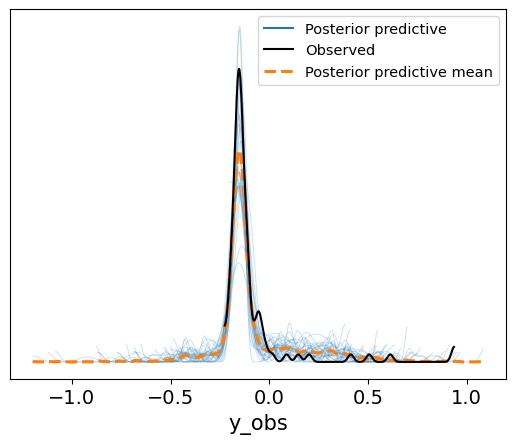

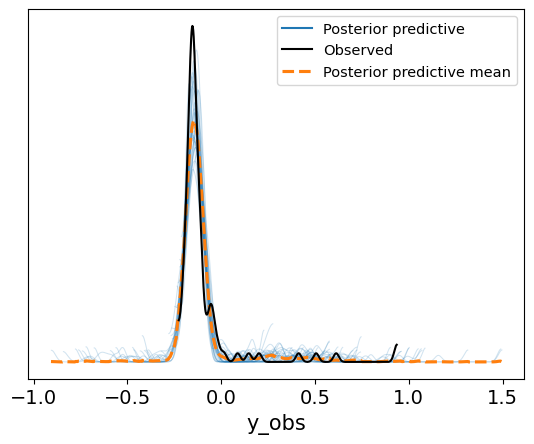

In [12]:
az.plot_ppc(ppc_with_covariates, num_pp_samples=30)
az.plot_ppc(ppc_basic, num_pp_samples=30)

In [13]:
# compare the models using the LOO-CV method
df_comp_loo = az.compare({"with_covariates": trace_with_covariates, "basic": trace_basic}, ic="loo")
df_comp_loo

/Users/tie_zhao/miniconda3/envs/pymc5/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/tie_zhao/miniconda3/envs/pymc5/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
basic,0,126.964308,6.256330,0.000000,0.846591,14.864955,0.000000,True,log
with_covariates,1,118.991020,6.013172,7.973288,0.153409,14.109828,4.892838,True,log


In [14]:
# calculate the prediction errors for the models
ppc_with_covariates_error = (
    ppc_with_covariates.posterior_predictive["y_obs"].mean(("chain", "draw")) - protein_levels
)

ppc_basic_error = (
    ppc_basic.posterior_predictive["y_obs"].mean(("chain", "draw")) - protein_levels
)


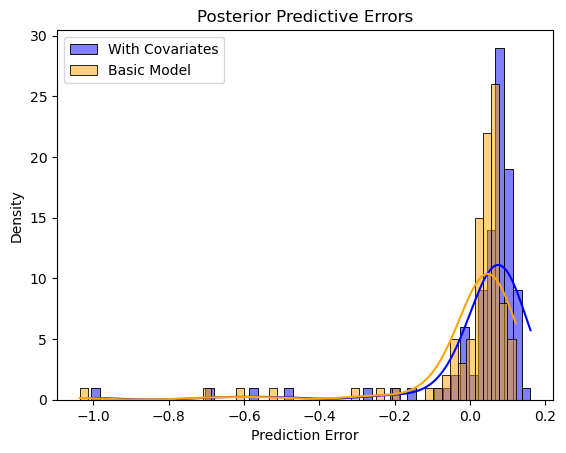

In [15]:
# Plot the posterior predictive errors
sns.histplot(ppc_with_covariates_error, kde=True, label="With Covariates", color="blue")
sns.histplot(ppc_basic_error, kde=True, label="Basic Model", color="orange")
plt.legend()
plt.title("Posterior Predictive Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.show()

In [16]:
import numpy as np
import scipy.stats as stats

# perform a Mann-Whitney U test to compare the prediction errors

median_with_covariates = np.median(ppc_with_covariates_error)
median_basic = np.median(ppc_basic_error)

median_diff = median_with_covariates - median_basic

print(f"Median of ppc_with_covariates_error: {median_with_covariates}")
print(f"Median of ppc_basic_error: {median_basic}")
print(f"Median difference: {median_diff}")

u_stat, p_value = stats.mannwhitneyu(ppc_with_covariates_error, ppc_basic_error, alternative='two-sided')

print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    if median_diff > 0:
        print("ppc_with_covariates_error is significantly greater than ppc_basic_error")
    else:
        print("ppc_with_covariates_error is significantly less than ppc_basic_error")
else:
    print("No significant difference between ppc_with_covariates_error and ppc_basic_error")

Median of ppc_with_covariates_error: 0.07371944099474456
Median of ppc_basic_error: 0.045935305761449094
Median difference: 0.027784135233295468
U-statistic: 6756.0
P-value: 1.7918130801118445e-05
ppc_with_covariates_error is significantly greater than ppc_basic_error
